In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Генерация данных
#### С помощью make_moons генерируем 200 точек с небольшим шумом

In [2]:
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

#### Визуализируем данные на плоскости

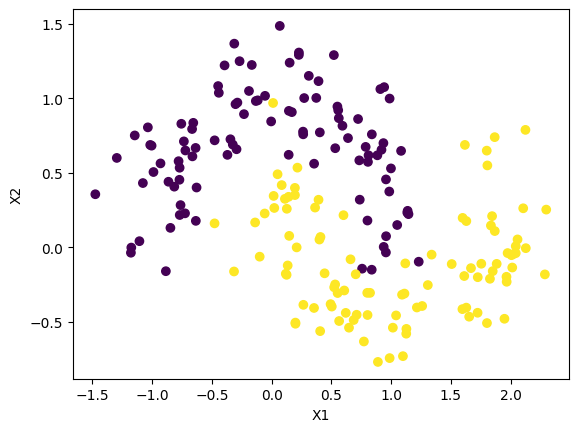

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Построение MLP
#### Архитектура нейронной сети:
1. Первый линейный слой — принимает 2 признака входных данных и отдает 4 нейрона на выход. Выполняет линейное преобразование y = Wx + b, где W - матрица весов, x - входные данные, b - смещение;
2. ReLU — функция активации f(x) = max(0, x). Вводит нелинейность в модель, что позволяет сети обучаться сложным зависимостям;
3. Второй линейный слой — принимает 4 нейрона из первого слоя + ReLU и преобразует их в 1 выходной нейрон - предсказание вероятности принадлежности к одному из классов;
4. Sigmoid — функция активации, преобразующая значение в диапазон [0, 1]: f(x) = 1 / (1 + exp(-x)). Если выход > 0.5, предсказываем класс 1, иначе - класс 0.

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Входной слой
        self.hidden = nn.Linear(2, 4)
        self.relu = nn.ReLU()
        # Выходной слой
        self.output = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


#### Функции потерь и оптимизатора
В качестве функции потерь выбираем классическую для задач бинарной классификации BCELoss:


$L = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i)]$


где $y_i$ — истинная метка (0 или 1),
$p_i$ — предсказанная вероятность,
$N$ — количество примеров.


В качестве оптимизатора выбираем SGD, как самый простой метод оптимизации, где веса обновляются по формуле:


$w_{t+1} = w_t - \eta \cdot \nabla L(w_t)$


где $w_t$ — текущие веса,
$\eta$ — скорость обучения (learning rate, у нас 0.01),
$\nabla L(w_t)$ — градиент функции потерь.
Это позволяет легко понять, как модель обучается, и настроить параметры

In [5]:
model = MLP()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) 

# Работа с данными
#### Разделяем данные на обучающую (80%) и тестовую (20%) выборки

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Преобразование данных в тензоры PyTorch

In [7]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# Обучение MLP
#### Прогоняем 1000 эпох и строим график потерь

In [8]:
losses = []
epochs = 1000

for epoch in range(epochs):
    
    ''' Прямой проход '''
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    ''' Обратный проход и оптимизация '''
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Эпоха [{epoch+1}/{epochs}], loss: {loss.item():.4f}')

Эпоха [100/1000], loss: 0.6811
Эпоха [200/1000], loss: 0.6656
Эпоха [300/1000], loss: 0.6464
Эпоха [400/1000], loss: 0.6213
Эпоха [500/1000], loss: 0.5906
Эпоха [600/1000], loss: 0.5556
Эпоха [700/1000], loss: 0.5186
Эпоха [800/1000], loss: 0.4826
Эпоха [900/1000], loss: 0.4497
Эпоха [1000/1000], loss: 0.4216


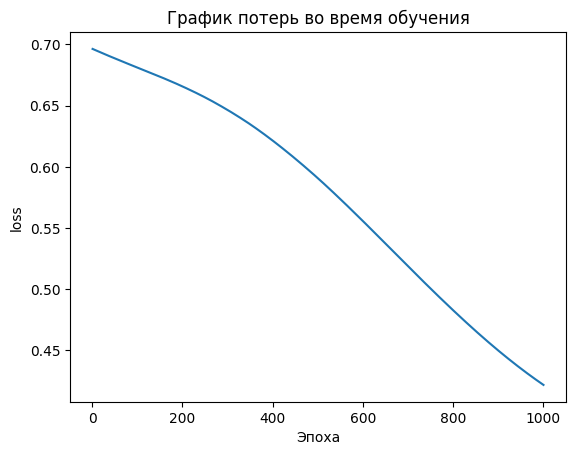

In [9]:
plt.plot(range(1, epochs + 1), losses)
plt.title('График потерь во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('loss')
plt.show()

#### Оценка точности модели

In [10]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_binary = (y_pred >= 0.5).float() # Об этом распределении упоминал в архитектуре MLP
    accuracy = (y_pred_binary.eq(y_test).sum().item() / y_test.size(0)) * 100
    print(f'Точность на тестовых данных: {accuracy:.2f}%')


Точность на тестовых данных: 82.50%


# XOR
#### Создаем таблицу истинности

In [11]:
X_xor = np.array([
    [0, 0], 
    [0, 1], 
    [1, 0], 
    [1, 1]
])
y_xor = np.array([
    [0], 
    [1], 
    [1], 
    [0]
])

#### Преобразование данных в тензоры PyTorch

In [12]:
X_xor = torch.FloatTensor(X_xor)
y_xor = torch.FloatTensor(y_xor)

In [13]:
model_xor = MLP()
optimizer_xor = optim.SGD(model_xor.parameters(), lr=0.01)
criterion_xor = nn.BCELoss()

# Обучение MLP
#### Прогоняем 1000 эпох и строим график потерь на той же модели

In [14]:
losses_xor = []
for epoch in range(1000):
    
    ''' Прямой проход '''
    outputs = model_xor(X_xor)
    loss = criterion_xor(outputs, y_xor)
    
    ''' Обратный проход и оптимизация '''
    optimizer_xor.zero_grad()
    loss.backward()
    optimizer_xor.step()
    
    losses_xor.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Эпоха [{epoch+1}/{epochs}], loss: {loss.item():.4f}')

Эпоха [100/1000], loss: 0.6713
Эпоха [200/1000], loss: 0.6604
Эпоха [300/1000], loss: 0.6508
Эпоха [400/1000], loss: 0.6418
Эпоха [500/1000], loss: 0.6327
Эпоха [600/1000], loss: 0.6233
Эпоха [700/1000], loss: 0.6133
Эпоха [800/1000], loss: 0.6024
Эпоха [900/1000], loss: 0.5906
Эпоха [1000/1000], loss: 0.5782


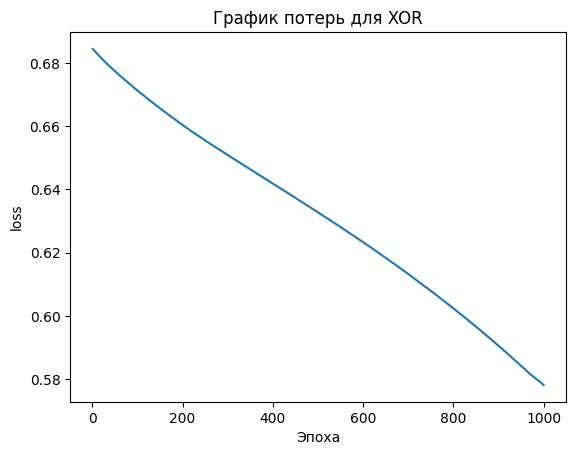

In [15]:
plt.plot(range(1, 1001), losses_xor)
plt.title('График потерь для XOR')
plt.xlabel('Эпоха')
plt.ylabel('loss')
plt.show()

#### Оценка точности модели

In [16]:
model_xor.eval()
with torch.no_grad():
    y_pred_xor = model_xor(X_xor)
    y_pred_binary_xor = (y_pred_xor >= 0.5).float()
    accuracy_xor = (y_pred_binary_xor.eq(y_xor).sum().item() / y_xor.size(0)) * 100
    print(f'Точность для XOR: {accuracy_xor:.2f}%')

Точность для XOR: 100.00%


#### Вариант визуализации разделяющей поверхности для XOR

In [17]:
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 100), np.linspace(-0.2, 1.2, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid)
Z = model_xor(grid_tensor).detach().numpy().reshape(xx.shape)

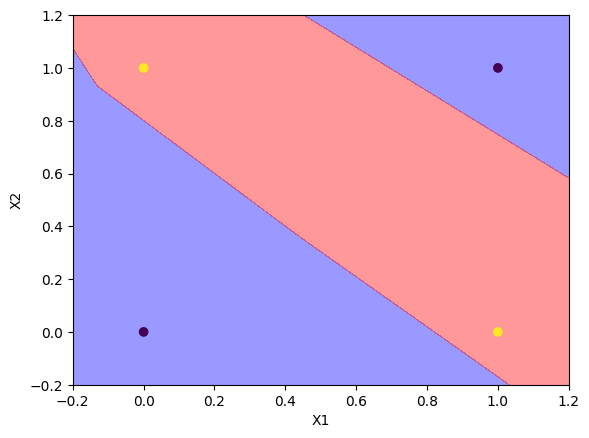

In [18]:
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.4, colors=['blue', 'red'])
plt.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor[:, 0])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#### Получаем контурную карту, где синий и красный цвета обозначают разные классы, что демонстрирует нелинейное разделение